# MOEA Diagnostics
This page contains Python code to generate basic visualizations for the diagnostics evaluation of multiobjective evolutionary algorithms (MOEAs). MOEA diagnostics are a systematic process of evaluating algorithmic performance. For background on MOEA diagnostics and an introductory tutorial see [this post](https://waterprogramming.wordpress.com/2015/08/25/moea-diagnostics-for-a-simple-test-case-part-13/).  For MOEA diagnostics on water resources applications see Reed et al., (2013), Zatarain et al., (2016), Zatarain et al., (2017) and Gupta et al., (2020).


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import ScalarMappable
import matplotlib
from scipy.ndimage import gaussian_filter

## Attainment Plots
MOEAs are stochastic tools that are initialize with random seeds (starting solutions) that may affect the quality of search results. To account for the inherent uncertainty in search we run multiple random seeds of an algorithm. Attainment plots are a helpful way of visualizing an algorithm's performance across random seeds. Attainment plots show the distribution of a MOEA performance metric across seeds and highlight the maximum performance achieved by an algorithm.

In the code below, four hypothetical algorithms are compared after running 20 random seeds each. The color of each bar represents the percentage of random seeds that achieve a given hypervolume, and the white points represent the best hypervolume achieved by each algorithm.


C:\Users\dgold\AppData\Local\Temp\ipykernel_27236\3490351943.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


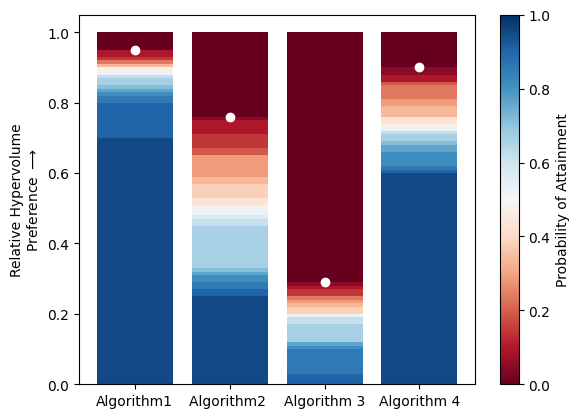

In [41]:
def attainment_plot(performance_file, metric):
    '''
    Creates an attainment plot comparing the performance of multiple algorithms across random seeds

    :param performance_file:            the path to a file containing performance metrics from diagnostic evaluation.
                                        the first row is assumed to be titles describing each algorithm

    :param metric:                      the name of the metric being plotted
    '''
    # load data
    performance_data = np.loadtxt(performance_file, delimiter=',', skiprows=1)

    # create a figure and get the axis object
    fig, ax = plt.subplots()

    # add a row of zeros
    performance_data = np.vstack((performance_data, np.ones(len(performance_data[0,:]))))

    # sort the hypervolume of each algorithm across all seeds from largest to smallest
    for i in range(len(performance_data[0,:])):
        performance_data[:,i] = np.sort(performance_data[:, i])[::-1]

    # plot a bar with the hypervolume achieved by each seed
    # start with 1 (full red), then highest, 2nd highest, etc.
    cmap = matplotlib.colormaps['RdBu'] # a color map for the plot
    for j in range(len(performance_data)):
        bar_color = (j)/len(performance_data) # color of the bar being plotted
        pcolor = cmap(bar_color) # pull color from colormap
        ax.bar(np.arange(len(performance_data[0,:])), performance_data[j,:], color=pcolor, alpha=1) # plot the seed

    # plot a the best hypervolume achieved by each Algorithm
    ax.scatter(np.arange(len(performance_data[0,:])), performance_data[1,:], color='w')

    # create a color bar
    sm = ScalarMappable(cmap= cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Probability of Attainment')

    # format the plot
    #ax.set_xticks(np.arange(4))
    title_df = pd.read_csv(performance_file)
    #print(list(title_df.columns))
    ax.set_xticks(np.arange(len(performance_data[0,:])))
    ax.set_xticklabels(title_df.columns)
    ax.set_ylabel(metric +'\nPreference $\longrightarrow$')

#Example Usage
attainment_plot('HV_20_Seeds.csv', 'Relative Hypervolume')

## Control Maps
Many MOEAs have complex parameterizations that may impact their ability to solve challenging multiobjective problems. Control maps are one way we can visualize how an algorithm's performance varies across different parameterizations. Control maps are usually two dimensional projections of sampled parameters, with each axis on the map representing a different parameter. The algorithm's performance at different parameter combinations is shown as the color on the map. An advantage of some high quality algorithms such as the Borg MOEA is that they are relatively insensitive to their parameterization, and their performance is mainly controlled by the number of function evaluations (NFEs) performed.

In the example below, the control map shows an algorithm that is sensitive to both the NFEs and intial population size, indicating that users must be careful of their parameterization when using this algorithm.


C:\Users\dgold\AppData\Local\Temp\ipykernel_32940\4004799671.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


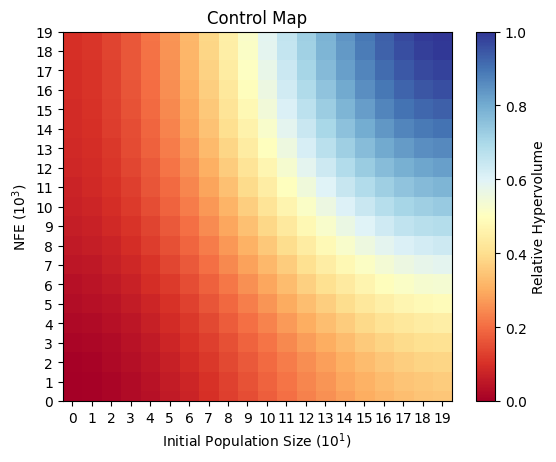

In [24]:
def control_plot(control_data, parameter_1, parameter_2):
    '''
    Creates a two dimensional control plot for MOEA performance across many parameterizations

    :param control_data:                the path to a csv file with performance data aranged as an nxn where n is the number of parameter samples
    :param parameter_1                  the name of the parameter being plotted on the horizontal axis
    :param parameter_2                  the name of the parameter being plotted on the vertical axis
    '''

    metrics = np.loadtxt(control_data, delimiter=',')
    filtered_metrics = gaussian_filter(metrics, sigma=5)

    fig, ax = plt.subplots()
    cmap = plt.get_cmap('RdYlBu')


    im = ax.imshow(filtered_metrics, cmap=cmap)
    ax.set_ylim([0,len(filtered_metrics[0,:])-1])
    ax.set_yticks(np.arange(len(filtered_metrics[:,0])))
    ax.set_xticks(np.arange(len(filtered_metrics[0,:])))
    ax.set_ylabel(parameter_2)
    ax.set_xlabel(parameter_1)
    ax.set_title('Control Map')

    # create a color bar
    sm = ScalarMappable(cmap= cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Relative Hypervolume')

control_plot('Control_data.csv', 'Initial Population Size ($10^1$)', 'NFE ($10^3$)')

## Runtime Dynamics

Another important way can compare algorithms is by visualizing the runtime dynamics - the way the algorithm performs during the search. We do this by tracking performance metrics during the search and plotting the performance against the NFEs. In the chart below I plot the performance of two algorithms on a hypothetical test problem. Here the max and min across seeds is plotted as a shaded region, and the mean performance is plotted as a solid line for each algorithm.

Text(0.5, 1.0, 'Runtime Dynamics')

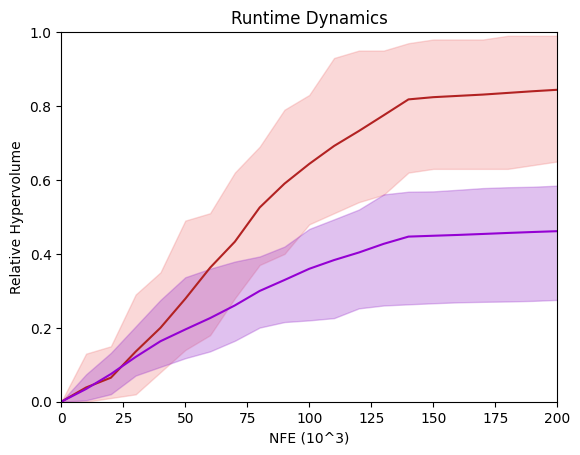

In [20]:
import seaborn as sns
sns.set()
runtime_1 = np.loadtxt('Alg1_runtime.csv', delimiter=',', skiprows=1)
runtime_1 = np.vstack((np.zeros(21), runtime_1))

maxes_1 = runtime_1[:,1:].max(axis=1)
mins_1 = runtime_1[:,1:].min(axis=1)
means_1 = runtime_1[:,1:].mean(axis=1)

runtime_2 = np.loadtxt('Alg2_runtime.csv', delimiter=',', skiprows=1)
runtime_2 = np.vstack((np.zeros(21), runtime_2))

maxes_2 = runtime_2[:,1:].max(axis=1)
mins_2 = runtime_2[:,1:].min(axis=1)
means_2 = runtime_2[:,1:].mean(axis=1)

fig, ax = plt.subplots()
ax.fill_between(runtime_1[:,0], mins_1, maxes_1, alpha=.3, color='lightcoral')
ax.plot(runtime_1[:,0], means_1, color='firebrick')
ax.fill_between(runtime_2[:,0], mins_2, maxes_2, alpha=.3, color='darkorchid')
ax.plot(runtime_2[:,0], means_2, color='darkviolet')

ax.set_xlim([0,200])
ax.set_ylim([0,1])
ax.set_xlabel('NFE (10^3)')
ax.set_ylabel('Relative Hypervolume')
ax.set_title('Runtime Dynamics')

## Multiobjective trade-offs
Finally, we can visualize the implications of algorithmic performance by plotting the Pareto approximate sets across multiple objectives. An important tool for high dimensional problems is the parallel axis plot. For an introduction to parallel axis plots, see [this post](https://waterprogramming.wordpress.com/2020/11/09/parallel-axis-plots-for-the-absolute-beginner/).

Pandas has a simple tool for making these plots that are useful for data with multiple categories (for example different algorithms). Fo

Text(0.5, 1.0, 'Approximate Pareto Sets')

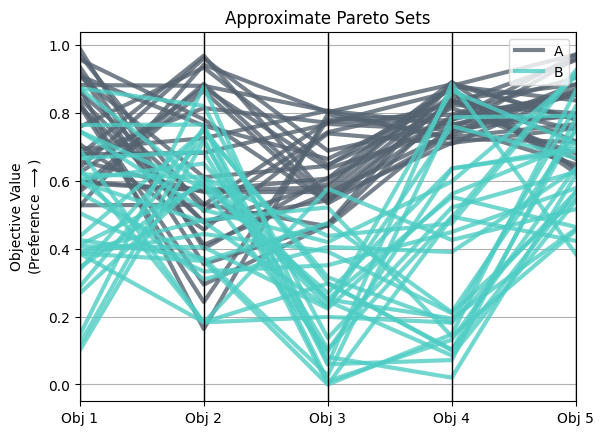

In [19]:
from pandas.plotting import parallel_coordinates

objs = pd.read_csv('objs_data.csv')
fig, ax =plt.subplots()
parallel_coordinates(objs, 'Algorithm', linewidth=3, alpha=.8, ax=ax, color = ('#556270', '#4ECDC4'))
ax.set_ylabel('Objective Value\n(Preference $\longrightarrow$)')
ax.set_title('Approximate Pareto Sets')

## References
Gupta, R. S., Hamilton, A. L., Reed, P. M., & Characklis, G. W. (2020). Can modern multi-objective evolutionary algorithms discover high-dimensional financial risk portfolio tradeoffs for snow-dominated water-energy systems?. Advances in water resources, 145, 103718.

Reed, P. M., Hadka, D., Herman, J. D., Kasprzyk, J. R., & Kollat, J. B. (2013). Evolutionary multiobjective optimization in water resources: The past, present, and future. Advances in water resources, 51, 438-456.

Salazar, J. Z., Reed, P. M., Herman, J. D., Giuliani, M., & Castelletti, A. (2016). A diagnostic assessment of evolutionary algorithms for multi-objective surface water reservoir control. Advances in water resources, 92, 172-185.

Salazar, J. Z., Reed, P. M., Quinn, J. D., Giuliani, M., & Castelletti, A. (2017). Balancing exploration, uncertainty and computational demands in many objective reservoir optimization. Advances in water resources, 109, 196-210.